In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [89]:
p = 0.2
df = pd.read_csv(
    "../data/training.1600000.processed.noemoticon.csv", 
    header=None, encoding="ISO-8859-1", dtype=str, skiprows=lambda i: i>0 and random.random() > p)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
3,0,1467812579,Mon Apr 06 22:20:17 PDT 2009,NO_QUERY,pardonlauren,I just re-pierced my ears
4,0,1467813782,Mon Apr 06 22:20:34 PDT 2009,NO_QUERY,gi_gi_bee,@FakerPattyPattz Oh dear. Were you drinking ou...


In [90]:
df.shape

(319443, 6)

Tweet length is more or less normally distributed.

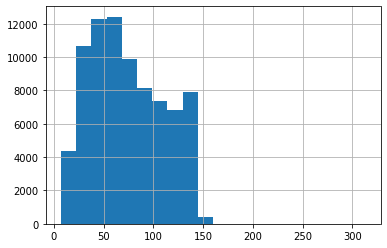

In [4]:
df.iloc[:, 5].map(lambda x: len(x)).hist(bins=20);

In [5]:
df.iloc[:, 5].map(lambda x: len(x)).describe()

count    80235.000000
mean        74.028304
std         36.446628
min          7.000000
25%         44.000000
50%         69.000000
75%        104.000000
max        313.000000
Name: 5, dtype: float64

We would expect tweets to fall under the 140 char limit. The outliers could be including URLs as text. We will probably need to remove URLs before modeling.

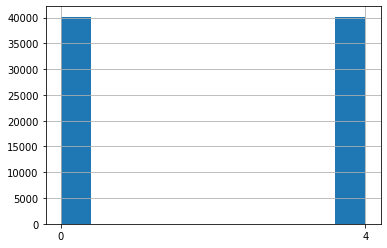

In [6]:
df[0].hist();

Luckily the classes in the dataset are perfectly balanced so we don't need to perform any balancing during the modeling steps.

## Processing

### Removing URLs

In [4]:
df[5] = df[5].str.replace(r'https?://\S+', "")

/tmp/ipykernel_17685/1163221978.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df[5] = df[5].str.replace(r'https?://\S+', "")


### Removing special characters

In [5]:
df[5] = df[5].str.extractall(r'([A-Za-z]+)').groupby(level=0).agg(" ".join)

### Enforce lowercase

In [6]:
df[5] = df[5].str.lower()

### Tokenize

In [14]:
from nltk import word_tokenize
tokenized = df[5].map(lambda x: word_tokenize(x))

### Lemmatize

In [16]:
from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in tokenized]

### Remove stopwords

In [9]:
from nltk.corpus import stopwords

In [11]:
stops = set(stopwords.words('english'))

In [17]:
processed = [[word for word in sentence if word not in stops] for sentence in lemmatized]

Create function for re-use in a pipeline

In [8]:
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize

stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(sentence: str):
    sentence = re.sub(r'https?://\S+', "", sentence)
    sentence = re.sub(r'[^A-Za-z ]', "", sentence)
    sentence = sentence.lower()
    tokenized = word_tokenize(sentence)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
    lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in lemmatized]
    return lemmatized

In [91]:
processed = df[5].map(process_text)

## Modeling

Use pretrained Word2Vec to perform embedding on the tokenized texts. A model pre-trained on twitter data seems appropriate for this dataset.

In [92]:
import gensim.downloader as api
word2vec_transfer = api.load("glove-twitter-50")

In [93]:
def create_embedding(tokenized: list, w2v):
    output = []
    for word in tokenized:
        if word in w2v:
            output.append(w2v.get_vector(word, norm=True))
    return np.array(output)

In [94]:
embedded = processed.map(lambda x: create_embedding(x, word2vec_transfer))

In [95]:
del word2vec_transfer

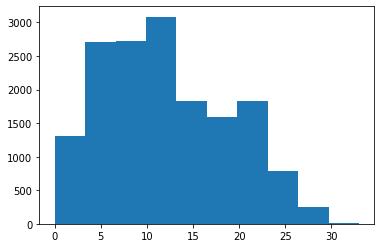

In [14]:
plt.hist([len(arr) for arr in embedded.values]);

In [96]:
from tensorflow.keras.utils import pad_sequences

In [97]:
padded = pad_sequences(embedded.values, padding="post", dtype="float32")

In [98]:
padded.shape

(319443, 35, 50)

In [18]:
padded.dtype

dtype('float32')

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape=(33, 50)))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [99]:
y = df[0].map({'0':0, '4':1})

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.3)

In [22]:
import tensorflow as tf

In [53]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True)
with tf.device('/cpu:0'):
    model = init_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[es], validation_split=0.3)

Epoch 1/100
247/247 [==============================] - 15s 36ms/step - loss: 0.6562 - accuracy: 0.6167 - val_loss: 0.6142 - val_accuracy: 0.6698
Epoch 2/100
247/247 [==============================] - 8s 31ms/step - loss: 0.5878 - accuracy: 0.6925 - val_loss: 0.5897 - val_accuracy: 0.6887
Epoch 3/100
247/247 [==============================] - 8s 32ms/step - loss: 0.5694 - accuracy: 0.7057 - val_loss: 0.5752 - val_accuracy: 0.6979
Epoch 4/100
247/247 [==============================] - 8s 31ms/step - loss: 0.5603 - accuracy: 0.7122 - val_loss: 0.5751 - val_accuracy: 0.7002
Epoch 5/100
247/247 [==============================] - 7s 28ms/step - loss: 0.5531 - accuracy: 0.7158 - val_loss: 0.5703 - val_accuracy: 0.7056
Epoch 6/100
247/247 [==============================] - 7s 30ms/step - loss: 0.5471 - accuracy: 0.7180 - val_loss: 0.5620 - val_accuracy: 0.7085
Epoch 7/100
247/247 [==============================] - 7s 28ms/step - loss: 0.5437 - accuracy: 0.7149 - val_loss: 0.5607 - val_accuracy

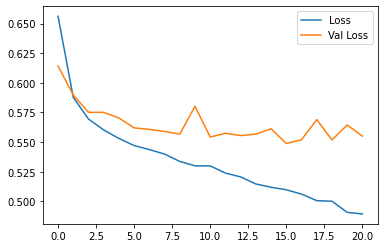

In [54]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend();

In [55]:
with tf.device('/cpu:0'):
    res = model.evaluate(X_test, y_test)
    print(res)

152/152 [==============================] - 1s 8ms/step - loss: 0.5504 - accuracy: 0.7158
[0.5503585934638977, 0.715791642665863]


72% accuracy on the test set is better than the baseline (50% on the balanced set). The loss on the train set is still quite high so I want to see if we can get the model to overfit on the train set first and then pull back from there; this first model might be too simple.

In [59]:
es = EarlyStopping(patience=5, restore_best_weights=True)
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape=(33, 50)))
    model.add(layers.LSTM(10, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[es], validation_split=0.3)

Epoch 1/100
247/247 [==============================] - 37s 103ms/step - loss: 0.6596 - accuracy: 0.6100 - val_loss: 0.6186 - val_accuracy: 0.6713
Epoch 2/100
247/247 [==============================] - 15s 61ms/step - loss: 0.5959 - accuracy: 0.6857 - val_loss: 0.5945 - val_accuracy: 0.6896
Epoch 3/100
247/247 [==============================] - 16s 63ms/step - loss: 0.5761 - accuracy: 0.6984 - val_loss: 0.5840 - val_accuracy: 0.6896
Epoch 4/100
247/247 [==============================] - 17s 71ms/step - loss: 0.5673 - accuracy: 0.7059 - val_loss: 0.5787 - val_accuracy: 0.6952
Epoch 5/100
247/247 [==============================] - 16s 63ms/step - loss: 0.5584 - accuracy: 0.7090 - val_loss: 0.5746 - val_accuracy: 0.7029
Epoch 6/100
247/247 [==============================] - 19s 79ms/step - loss: 0.5577 - accuracy: 0.7089 - val_loss: 0.5740 - val_accuracy: 0.6970
Epoch 7/100
247/247 [==============================] - 20s 79ms/step - loss: 0.5531 - accuracy: 0.7134 - val_loss: 0.5678 - val_a

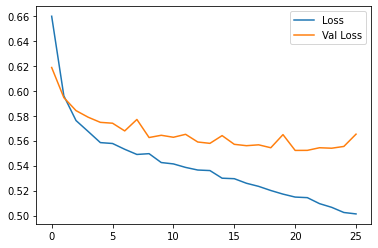

In [60]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend();

In [61]:
with tf.device('/cpu:0'):
    res = model.evaluate(X_test, y_test)
    print(res)

152/152 [==============================] - 2s 15ms/step - loss: 0.5502 - accuracy: 0.7193
[0.5501821637153625, 0.7193055152893066]


Increased test performance, but still haven't ended up overfitting on the test set so network might not be complex enough. Increase learning rate to converge faster.

In [119]:
from tensorflow.keras.optimizers import Adam
mlflow.tensorflow.autolog()
es = EarlyStopping(patience=5, restore_best_weights=True)
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape=(35, 50)))
    model.add(layers.LSTM(20, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.0008)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[es], validation_split=0.3)
    

2023/08/14 22:31:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023-08-14 22:32:45.956509: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1095689000 exceeds 10% of free system memory.
2023/08/14 22:32:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Changing param values is not allowed. Param with key='opt_learning_rate' was already logged with value='0.01' for run ID='4d38ff73071d4ff18bc7dfe01e7113c0'. Attempted logging new value '0.0008'.

The cause of this error is typically due to repeated calls
to an individual run_id event logging.

Incorrect Example:
---------------------------------------
with mlflow.start_run():
    mlflow.log_param("depth", 3)
    mlflow.log_param("depth", 5)
---------------------------------------

Which will throw an 

Epoch 1/100
4892/4892 [==============================] - 319s 63ms/step - loss: 0.5524 - accuracy: 0.7122 - val_loss: 0.5263 - val_accuracy: 0.7335
Epoch 2/100
4892/4892 [==============================] - 247s 50ms/step - loss: 0.5129 - accuracy: 0.7432 - val_loss: 0.4992 - val_accuracy: 0.7542
Epoch 3/100
4892/4892 [==============================] - 237s 48ms/step - loss: 0.4940 - accuracy: 0.7575 - val_loss: 0.5012 - val_accuracy: 0.7583
Epoch 4/100
4892/4892 [==============================] - 227s 46ms/step - loss: 0.4834 - accuracy: 0.7642 - val_loss: 0.4823 - val_accuracy: 0.7676
Epoch 5/100
4892/4892 [==============================] - 226s 46ms/step - loss: 0.4756 - accuracy: 0.7696 - val_loss: 0.4755 - val_accuracy: 0.7713
Epoch 6/100
4892/4892 [==============================] - 230s 47ms/step - loss: 0.4703 - accuracy: 0.7737 - val_loss: 0.4898 - val_accuracy: 0.7635
Epoch 7/100
4892/4892 [==============================] - 260s 53ms/step - loss: 0.4647 - accuracy: 0.7769 - val_

INFO:tensorflow:Assets written to: /tmp/tmpwo91cl2x/model/data/model/assets
2023/08/15 00:17:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: module 'tensorflow.keras' has no attribute '__version__'


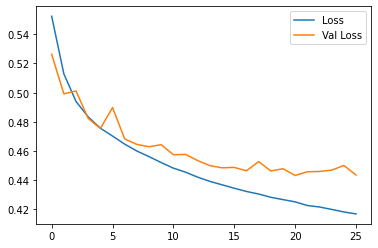

In [121]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend();

In [122]:
with tf.device('/cpu:0'):
    res = model.evaluate(X_test, y_test)
    print(res)

2995/2995 [==============================] - 36s 12ms/step - loss: 0.4446 - accuracy: 0.7895
[0.4446370601654053, 0.7895192503929138]


In [120]:
model.save("twitter_lstm_2.keras")

In [111]:
X_test[0:1,:, :].shape

(1, 35, 50)

In [113]:
with tf.device('/cpu:0'):
    prediction = model.predict(X_test[0:1, :, :])

1/1 [==============================] - 7s 7s/step


In [118]:
float(prediction[0,0])

0.5355266332626343

Consistently decreases loss on the train set. With more epochs and no early stopping, it will end up overfitting. Going to reduce learning rate a bit, and remove one of the layers.

In [65]:
from tensorflow.keras.optimizers import Adam
es = EarlyStopping(patience=10, restore_best_weights=True)
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape=(33, 50)))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, 
                        epochs=100, batch_size=32, callbacks=[es], validation_split=0.3)

Epoch 1/100
247/247 [==============================] - 31s 102ms/step - loss: 0.6095 - accuracy: 0.6649 - val_loss: 0.5766 - val_accuracy: 0.7002
Epoch 2/100
247/247 [==============================] - 8s 34ms/step - loss: 0.5670 - accuracy: 0.7076 - val_loss: 0.5855 - val_accuracy: 0.6929
Epoch 3/100
247/247 [==============================] - 8s 34ms/step - loss: 0.5470 - accuracy: 0.7171 - val_loss: 0.5554 - val_accuracy: 0.7100
Epoch 4/100
247/247 [==============================] - 10s 41ms/step - loss: 0.5334 - accuracy: 0.7281 - val_loss: 0.5485 - val_accuracy: 0.7259
Epoch 5/100
247/247 [==============================] - 8s 32ms/step - loss: 0.5205 - accuracy: 0.7371 - val_loss: 0.5464 - val_accuracy: 0.7292
Epoch 6/100
247/247 [==============================] - 8s 32ms/step - loss: 0.5049 - accuracy: 0.7477 - val_loss: 0.5389 - val_accuracy: 0.7324
Epoch 7/100
247/247 [==============================] - 9s 38ms/step - loss: 0.4936 - accuracy: 0.7516 - val_loss: 0.5498 - val_accura

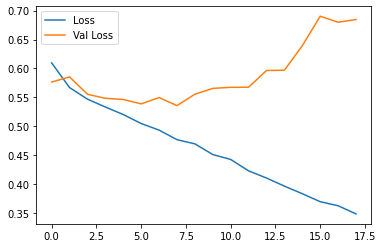

In [66]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend();

In [67]:
with tf.device('/cpu:0'):
    res = model.evaluate(X_test, y_test)
    print(res)

152/152 [==============================] - 8s 9ms/step - loss: 0.5406 - accuracy: 0.7261
[0.5406022667884827, 0.726126492023468]


In [74]:
import mlflow

mlflow.tensorflow.autolog()
es = EarlyStopping(patience=10, restore_best_weights=True)
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape=(33, 50)))
    model.add(layers.LSTM(20, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[es], validation_split=0.3)

2023/08/14 18:36:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023/08/14 18:36:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1db815ae0bfd45638394c6de884b9332', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
247/247 [==============================] - 20s 56ms/step - loss: 0.6685 - accuracy: 0.6011 - val_loss: 0.6320 - val_accuracy: 0.6462
Epoch 2/100
247/247 [==============================] - 12s 47ms/step - loss: 0.5984 - accuracy: 0.6838 - val_loss: 0.5917 - val_accuracy: 0.6855
Epoch 3/100
247/247 [==============================] - 12s 49ms/step - loss: 0.5778 - accuracy: 0.6949 - val_loss: 0.5761 - val_accuracy: 0.6973
Epoch 4/100
247/247 [==============================] - 13s 51ms/step - loss: 0.5640 - accuracy: 0.7063 - val_loss: 0.5735 - val_accuracy: 0.7064
Epoch 5/100
247/247 [==============================] - 12s 48ms/step - loss: 0.5578 - accuracy: 0.7105 - val_loss: 0.5658 - val_accuracy: 0.6976
Epoch 6/100
247/247 [==============================] - 12s 51ms/step - loss: 0.5520 - accuracy: 0.7152 - val_loss: 0.5668 - val_accuracy: 0.7017
Epoch 7/100
247/247 [==============================] - 12s 50ms/step - loss: 0.5495 - accuracy: 0.7128 - val_loss: 0.5695 - val_ac

INFO:tensorflow:Assets written to: /tmp/tmp8h6l650a/model/data/model/assets
2023/08/14 18:42:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: module 'tensorflow.keras' has no attribute '__version__'


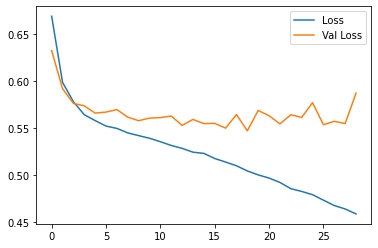

In [75]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend();

In [76]:
with tf.device('/cpu:0'):
    res = model.evaluate(X_test, y_test)
    print(res)

152/152 [==============================] - 2s 13ms/step - loss: 0.5496 - accuracy: 0.7201
[0.5496038794517517, 0.7201322913169861]


In [84]:
from tensorflow.keras.optimizers import Adam
mlflow.tensorflow.autolog()
es = EarlyStopping(patience=5, restore_best_weights=True)
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape=(33, 50)))
    model.add(layers.Conv1D(16, 3, activation="relu"))
    model.add(layers.LSTM(20, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.0007)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[es], validation_split=0.3)

2023/08/14 20:13:04 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023/08/14 20:13:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5bef33a60c01468bb40a96f22e0c7b15', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
247/247 [==============================] - 13s 40ms/step - loss: 0.6689 - accuracy: 0.5708 - val_loss: 0.6310 - val_accuracy: 0.6660
Epoch 2/100
247/247 [==============================] - 9s 36ms/step - loss: 0.5986 - accuracy: 0.6790 - val_loss: 0.6132 - val_accuracy: 0.6689
Epoch 3/100
247/247 [==============================] - 9s 37ms/step - loss: 0.5759 - accuracy: 0.6977 - val_loss: 0.5999 - val_accuracy: 0.6914
Epoch 4/100
247/247 [==============================] - 9s 37ms/step - loss: 0.5659 - accuracy: 0.7052 - val_loss: 0.5775 - val_accuracy: 0.6940
Epoch 5/100
247/247 [==============================] - 9s 37ms/step - loss: 0.5580 - accuracy: 0.7158 - val_loss: 0.5927 - val_accuracy: 0.6994
Epoch 6/100
247/247 [==============================] - 10s 39ms/step - loss: 0.5467 - accuracy: 0.7195 - val_loss: 0.5623 - val_accuracy: 0.7082
Epoch 7/100
247/247 [==============================] - 9s 36ms/step - loss: 0.5327 - accuracy: 0.7289 - val_loss: 0.5878 - val_accurac

INFO:tensorflow:Assets written to: /tmp/tmpsj74tqux/model/data/model/assets
2023/08/14 20:15:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: module 'tensorflow.keras' has no attribute '__version__'


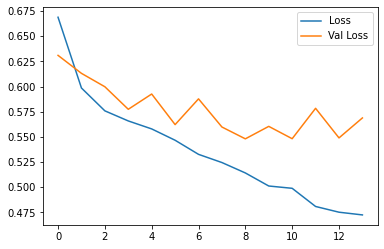

In [85]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend();

In [86]:
with tf.device('/cpu:0'):
    res = model.evaluate(X_test, y_test)
    print(res)

152/152 [==============================] - 2s 10ms/step - loss: 0.5427 - accuracy: 0.7201
[0.5426676869392395, 0.7201322913169861]
